In [ ]:
!pip uninstall -y tensorflow tensorflow-cpu tensorflow-gpu \
                 tensorflow_compression tensorflow-compression-ops

In [ ]:
!pip install --upgrade "tensorflow==2.14.0"

In [ ]:
# restart

In [ ]:
!pip install "tensorflow-compression==2.14.1"

In [ ]:
# restart

In [1]:
import tensorflow as tf, tensorflow_compression as tfc
import pkg_resources, inspect
print("TFC:", pkg_resources.get_distribution("tensorflow_compression").version)
print("TF :", tf.__version__)

2025-07-05 07:35:15.947993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-05 07:35:15.948052: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-05 07:35:15.948104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TFC: 2.14.1
TF : 2.14.0


In [2]:
#––– 1) Uyumlu tensorflow-compression kurulumu
!pip install -q --upgrade --no-deps tensorflow-compression==2.14.1

#––– 2) Modeller klasörünü yalnızca ilk kez klonla
import os, sys
if not os.path.isdir('/tfc'):
    !git clone --depth 1 https://github.com/tensorflow/compression /tfc

#––– 3) tfci.py’yi bulabilmesi için PYTHONPATH’e ekle
if '/tfc' not in sys.path:
    sys.path.insert(0, '/tfc')

#––– 4) Çalışma dizinini /tfc/models olarak ayarla
%cd /tfc/models

#––– 5) Kontrol: tfci başarıyla import ediliyor mu?
import tensorflow as tf, tensorflow_compression as tfc, tfci
print("TF :", tf.__version__)
print("TFC paketi yüklü ✓")
print("tfci modülü yüklendi ✓")

Cloning into '/tfc'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (318/318), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 318 (delta 129), reused 218 (delta 103), pack-reused 0 (from 0)
Receiving objects: 100% (318/318), 347.09 KiB | 2.36 MiB/s, done.
Resolving deltas: 100% (129/129), done.
/tfc/models
TF : 2.14.0
TFC paketi yüklü ✓
tfci modülü yüklendi ✓


In [3]:
import tensorflow as tf, tensorflow_compression as tfc
import pkg_resources, inspect
print("TFC:", pkg_resources.get_distribution("tensorflow_compression").version)
print("TF :", tf.__version__)

TFC: 2.14.1
TF : 2.14.0


In [4]:
import tensorflow as tf

if not tf.config.list_physical_devices('GPU'):
  print('WARNING: No GPU found. Might be slow!')
else:
  print('Found GPU.')

In [6]:

import os
import zipfile
import collections
from PIL import Image
import tensorflow as tf
import tfci
import urllib.request

# Sadece uyarıları göster
tf.get_logger().setLevel('WARN')

# Kaggle'da input olarak yüklediğin klasör
FILES_DIR = '/kaggle/input/anadolu-deneme/deneme'     # içindeki 3 görseli kullanacağız
OUT_DIR = '/kaggle/working/out'        # çıktıların yazılacağı yer
os.makedirs(OUT_DIR, exist_ok=True)

# Varsayılan resim URL'si (kullanmayacağız ama fonksiyon durabilir)
DEFAULT_IMAGE_URL = (
    'https://storage.googleapis.com/hific/clic2020/images/originals/ad249bba099568403dc6b97bc37f8d74.png'
)

# Namedtuple: çıktı bilgilerini tutar
File = collections.namedtuple('File', ['full_path', 'num_bytes', 'bpp'])

# (Colab'a özel display kodları çıkarıldı)

# Varsayılan resim indirecek fonksiyon (kullanmak istemezsen çağırmazsın)
def get_default_image(output_dir):
    output_path = os.path.join(output_dir, os.path.basename(DEFAULT_IMAGE_URL))
    print('Downloading', DEFAULT_IMAGE_URL, '\n->', output_path)
    urllib.request.urlretrieve(DEFAULT_IMAGE_URL, output_path)


In [9]:
# Kaggle ortamı için: Dosya yükleme yerine doğrudan klasörden okuma



# Model seçimi
model = 'hific-lo'  # ya da 'hific-mi', 'hific-hi'


In [10]:
if 'upload_custom_images' not in locals():
  print('ERROR: Please run the previous cell!')
  # Setting defaults anyway.
  upload_custom_images = False
  model = 'hific-lo'

Got the following files (3):
- Anadolu-TuzGl12.jpg:


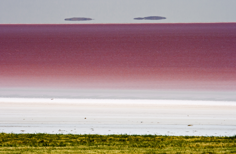

- Anadolu-ldeniz18.jpg:


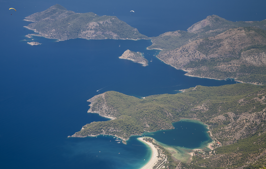

- Anadolu-SaldaGl11.jpg:


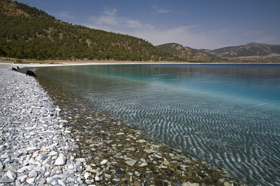

In [11]:
all_files = os.listdir(FILES_DIR)

all_files = os.listdir(FILES_DIR)
print(f'Got the following files ({len(all_files)}):')

for file_name in all_files:
  img = Image.open(os.path.join(FILES_DIR, file_name))
  w, h = img.size
  img = img.resize((w // 15, h // 15))
  print('- ' + file_name + ':')
  display(img)

In [13]:
SUPPORTED_EXT = {'.png', '.jpg'}

all_files = os.listdir(FILES_DIR)
if not all_files:
  raise ValueError("Please upload images!")

def get_bpp(image_dimensions, num_bytes):
  w, h = image_dimensions
  return num_bytes * 8 / (w * h)

def has_alpha(img_p):
  im = Image.open(img_p)
  return im.mode == 'RGBA'

all_outputs = []
models = ["hific-lo","hific-mi","hific-hi"]
for current_model in models:
    model = current_model
    for original_file_name in all_files:

        if os.path.isdir(original_file_name):
            continue
        if not any(original_file_name.endswith(ext) for ext in SUPPORTED_EXT):
            print('Skipping', original_file_name, '...')
            continue

        full_path = os.path.join(FILES_DIR, original_file_name)
        if has_alpha(full_path):
            print('Skipping because of alpha channel:', original_file_name)
            continue

        name_wo_ext, _ = os.path.splitext(original_file_name)
        compressed_path = os.path.join(OUT_DIR, f'{name_wo_ext}_{model}.tfci')
        output_path = os.path.join(OUT_DIR, f'{name_wo_ext}_{model}.png')

        if os.path.isfile(output_path):
            print('Exists already:', output_path)
            num_bytes = os.path.getsize(compressed_path)
            all_outputs.append(
                File(output_path, num_bytes,
                     get_bpp(Image.open(full_path).size, num_bytes)))
            continue

        print('Compressing', original_file_name, 'with', model, '...')
        tfci.compress(model, full_path, compressed_path)
        num_bytes = os.path.getsize(compressed_path)
        print(f'Compressed to {num_bytes} bytes.')

        print('Decompressing...')
        tfci.decompress(compressed_path, output_path)

        all_outputs.append(
            File(output_path, num_bytes,
                 get_bpp(Image.open(full_path).size, num_bytes)))


print('All done!')

Compressing Anadolu-TuzGl12.jpg with hific-lo ...
Compressed to 90265 bytes.
Decompressing...
Compressing Anadolu-ldeniz18.jpg with hific-lo ...
Compressed to 163374 bytes.
Decompressing...
Compressing Anadolu-SaldaGl11.jpg with hific-lo ...
Compressed to 298421 bytes.
Decompressing...
Compressing Anadolu-TuzGl12.jpg with hific-mi ...
Compressed to 224366 bytes.
Decompressing...
Compressing Anadolu-ldeniz18.jpg with hific-mi ...
Compressed to 318533 bytes.
Decompressing...
Compressing Anadolu-SaldaGl11.jpg with hific-mi ...
Compressed to 554611 bytes.
Decompressing...
Compressing Anadolu-TuzGl12.jpg with hific-hi ...
Compressed to 419120 bytes.
Decompressing...
Compressing Anadolu-ldeniz18.jpg with hific-hi ...
Compressed to 519981 bytes.
Decompressing...
Compressing Anadolu-SaldaGl11.jpg with hific-hi ...
Compressed to 837362 bytes.
Decompressing...
All done!


In [14]:
import os
from glob import glob

print("🔍 OUT klasöründe bulunan dosyalar:")
files = glob("/kaggle/working/out/*")
for f in files:
    print(" -", f)


🔍 OUT klasöründe bulunan dosyalar:
 - /kaggle/working/out/Anadolu-SaldaGl11_hific-lo.tfci
 - /kaggle/working/out/Anadolu-ldeniz18_hific-hi.tfci
 - /kaggle/working/out/Anadolu-ldeniz18_hific-lo.tfci
 - /kaggle/working/out/Anadolu-TuzGl12_hific-mi.tfci
 - /kaggle/working/out/Anadolu-TuzGl12_hific-lo.tfci
 - /kaggle/working/out/Anadolu-SaldaGl11_hific-mi.tfci
 - /kaggle/working/out/Anadolu-TuzGl12_hific-lo.png
 - /kaggle/working/out/Anadolu-ldeniz18_hific-lo.png
 - /kaggle/working/out/Anadolu-ldeniz18_hific-mi.tfci
 - /kaggle/working/out/Anadolu-TuzGl12_hific-mi.png
 - /kaggle/working/out/Anadolu-SaldaGl11_hific-mi.png
 - /kaggle/working/out/Anadolu-SaldaGl11_hific-hi.png
 - /kaggle/working/out/Anadolu-SaldaGl11_hific-hi.tfci
 - /kaggle/working/out/Anadolu-TuzGl12_hific-hi.png
 - /kaggle/working/out/Anadolu-ldeniz18_hific-mi.png
 - /kaggle/working/out/Anadolu-ldeniz18_hific-hi.png
 - /kaggle/working/out/Anadolu-TuzGl12_hific-hi.tfci
 - /kaggle/working/out/Anadolu-SaldaGl11_hific-lo.png


In [19]:
# refresh output directory

In [16]:
""""
from IPython.display import display, HTML
from PIL import Image
import os

def make_cell_large():  
    from IPython.display import Javascript
    display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))

def print_html(html):
    display(HTML(html + '<br/>'))

make_cell_large()

for file in all_outputs:
    print_html('<hr/>')
    print(f' {os.path.basename(file.full_path)} |  {file.num_bytes // 1000} kB |  {file.bpp:.4f} bpp')
    display(Image.open(file.full_path))
    print_html('<hr/>')

"""


'"\nfrom IPython.display import display, HTML\nfrom PIL import Image\nimport os\n\ndef make_cell_large():  \n    from IPython.display import Javascript\n    display(Javascript(\'google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})\'))\n\ndef print_html(html):\n    display(HTML(html + \'<br/>\'))\n\nmake_cell_large()\n\nfor file in all_outputs:\n    print_html(\'<hr/>\')\n    print(f\' {os.path.basename(file.full_path)} |  {file.num_bytes // 1000} kB |  {file.bpp:.4f} bpp\')\n    display(Image.open(file.full_path))\n    print_html(\'<hr/>\')\n\n'

In [ ]:
import zipfile
import os

zip_path = "/kaggle/working/anadolu.zip"
out_dir = "/kaggle/working/out"

with zipfile.ZipFile(zip_path, "w") as zipf:
    for f in all_outputs:
        # PNG
        if os.path.isfile(f.full_path):
            png_name = os.path.splitext(os.path.basename(f.full_path))[0]
            new_png_name = f"{png_name}-{f.bpp:.3f}bpp.png"
            zipf.write(f.full_path, arcname=new_png_name)

        # TFCI 
        tfci_path = f.full_path.replace(".png", ".tfci")
        if os.path.isfile(tfci_path):
            tfci_name = os.path.splitext(os.path.basename(tfci_path))[0]
            new_tfci_name = f"{tfci_name}.tfci"
            zipf.write(tfci_path, arcname=new_tfci_name)
        else:
            print(f"❌ TFCI bulunamadı: {tfci_path}")

print("📦 Hem PNG hem TFCI içeren ZIP oluşturuldu:", zip_path)
